# Chapter 7 : Telling birds from airplanes: Learning from images

### 1. Use torchvision to implement random cropping of the data.
* How are the resulting images different from the uncropped originals?
* What happens when you request the same image a second time?
* What is the result of training using randomly cropped images?

In this exercise we'll use the torchvision framework to train a model on a dataset called CIFAR10 which is provided by torchvision.\
First, we'll recall some example of the book : how to load CIFAR10, how images are labelized, how to use the *transforms* module... \
Then, we'll train a model on that dataset in regard to the exercise by considering a *classification problem*.

In [3]:
from torchvision import datasets
data_path = 'data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False) 
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

cifar10, cifar10_val

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train,
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test)

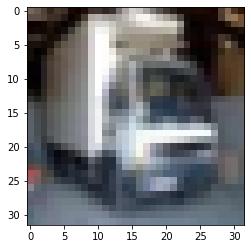

In [4]:
import matplotlib.pyplot as plt
img, label = cifar10[2001] # arbitrary image
img, label, class_names[label]

plt.imshow(img);

In [5]:
from torchvision import transforms
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

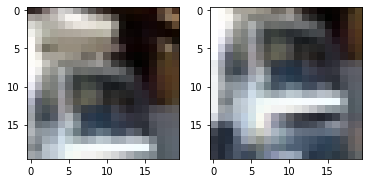

In [6]:
plt.subplot(121)
cropping = transforms.RandomCrop(20)
plt.imshow(cropping(img))

plt.subplot(122)
cropping = transforms.RandomCrop(20)
plt.imshow(cropping(img));

As expected, the resulting image is cropped top the size mentioned in the *RandomCrop* method. Since it's random, the crop isn't taken at the same location twice.

Now, let's build our dataset and train or model on it. We'll have to use Tensor instead of PIL images.

First, we transform the CIFAR10 dataset into Tensor to find the mean/std to normalized the dataset so that each channel has zero mean and unitary standard deviation. In the book, we can find the reasons why : "*keeping the data in the same range means it’s more likely that neurons have nonzero gradients and, hence, will learn sooner. Also, normalizing each channel so that it has the same distribution will ensure that channel information can be mixed and updated through gradient descent using the same learning rate*"

In [7]:
import torch
cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.RandomCrop(20)]))
imgs = torch.stack([img for img, _ in cifar10], dim=3)
print(imgs.shape)

torch.Size([3, 20, 20, 50000])


In [8]:
# Keeping the 3 channels and merging all the remaining dimensions into one
print(imgs.view(3,-1).shape)

# Finding the mean and std of the stack for normalization
mean = imgs.view(3,-1).mean(dim=1)
std = imgs.view(3,-1).std(dim=1)
print("mean : ", mean, "\nstd : ", std)

torch.Size([3, 20000000])
mean :  tensor([0.4905, 0.4708, 0.4348]) 
std :  tensor([0.2402, 0.2362, 0.2510])


In [9]:
preprocessor = transforms.Compose([transforms.ToTensor(),
                                 transforms.RandomCrop(20),
                                 transforms.Normalize((0.4903, 0.4707, 0.4347), (0.2402, 0.2361, 0.2507))])

In [10]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=preprocessor)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                          transform=preprocessor)
cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomCrop(size=(20, 20), padding=None)
               Normalize(mean=(0.4903, 0.4707, 0.4347), std=(0.2402, 0.2361, 0.2507))
           )

Since the crop is random, the mean and std of the stack will be slightly different each time so should be the normalization. Because this difference is small we'll stick to this normalization.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


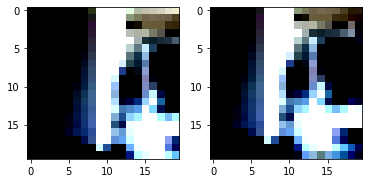

In [11]:
img1, _ = cifar10[2001]
img2, _ = cifar10[2001]

plt.subplot(121)
plt.imshow(img1.permute(1, 2, 0))

plt.subplot(122)
plt.imshow(img2.permute(1, 2, 0));

Surprisingly, the preprocessor seems to stick to each sample ! Each time we call the cifar10 variable, it calls the *transforms.Compose* preprocessing and a random cropping is execute too !

We recall the goal of this exercise : telling birds from airplanes. To work on different data, let's modify this by *telling trucks from ships*. So let's filter the data in CIFAR10.

In [12]:
label_map = {8: 0, 9: 1}
class_names = ['ship', 'truck']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [8, 9]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [8, 9]]

Each image has a size of 20x20 after cropping. And each one has 3 channel for the RGB colors. So the input features are 3x20x20 = 1200. \
Also, we need to interpret our output in terms of probabilities (it's either a truck or a ship), so we introduce the Softmax function : "*Softmax is a monotone function, in that lower values in the input will correspond to lower values in the output. However, it’s not scale invariant, in that the ratio between values is not preserved*".

Here, we can chose *nn.LogSoftmax* instead to be able to use the *negative log likelihood nn.NLLLoss* as our loss (see Chapter 7.2.5). And to be more Pytorch-like, we'll go with *nn.CrossEntropyLoss* which is the combination of using *nn.LogSoftmax* and *nn.NLLLoss* as it is explained in the end of the 7.2.6 section.

In [13]:
#Initilization
import torch.nn as nn
import torch.optim as optim
import time

n_out = 2
model = nn.Sequential(nn.Linear(1200, 512),
                     nn.Tanh(),
                     nn.Linear(512,n_out))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

Now we'd like to evaluate all the 10000 images, except it would be too much in a single batch and it may conducts the optimization process to get stuck in local minima. By shuffling samples at each epoch and estimating the gradient on a few samples at a time, we are introducing randomness in our gradient descent which helps convergence.

In [14]:
import time
from datetime import timedelta
start_time = time.time()



train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def training_loop(nb_epochs, model, optimizer, loss_fn, train_dataloader):
    for epoch in range(nb_epochs):
        for imgs, labels in train_dataloader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1)) # resulting in a (64x1200) Tensor
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
        
        if epoch == 1 or epoch == 2 or epoch %10 == 0:
            print("Epoch: %d, Training Loss: %f" % (epoch, float(loss)))
    

training_loop(100, model, optimizer, loss_fn, train_loader)



elapsed_time_secs = time.time() - start_time
msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg)

Epoch: 0, Training Loss: 0.528837
Epoch: 1, Training Loss: 0.578594
Epoch: 2, Training Loss: 0.429819
Epoch: 10, Training Loss: 0.274383
Epoch: 20, Training Loss: 0.543682
Epoch: 30, Training Loss: 0.256672
Epoch: 40, Training Loss: 0.514291
Epoch: 50, Training Loss: 0.391341
Epoch: 60, Training Loss: 0.166963
Epoch: 70, Training Loss: 0.036834
Epoch: 80, Training Loss: 0.123754
Epoch: 90, Training Loss: 0.070163
Execution took: 0:02:04 secs (Wall clock time)


Well, it's a good start : our model seems to provide a good fit on the train data. \
Let's compute the accuracy which is a more intuitive way to deal with classification problem.

In [15]:
### Train data accuracy
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1)) # prediction
        _, predicted = torch.max(outputs, dim=1) 
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy:", correct / total)

Accuracy: 0.9946


By using cropped images, the model seems to train correctly on the training set.

In [16]:
### Validation data accuracy
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1)) # prediction
        _, predicted = torch.max(outputs, dim=1) 
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy:", correct / total)

Accuracy: 0.752


On the contrary, the accuracy on unseen data is not satisfying : our model clearly overfits since it captures well the complexity of the training set but can't generalize enough on unseen data.

### 2. Switch loss functions (perhaps MSE).
* Does the training behavior change?

In [17]:
def training_loop2(nb_epochs, model, optimizer, loss_fn, train_dataloader):
    for epoch in range(nb_epochs):
        for imgs, labels in train_dataloader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1)) # resulting in a (64x1200) Tensor
            _, predicted = torch.max(outputs, dim=1)
            loss = loss_fn(predicted.to(torch.float32), labels)
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
        
        if epoch == 1 or epoch == 2 or epoch %10 == 0:
            print("Epoch: %d, Training Loss: %f" % (epoch, float(loss)))

In [18]:
n_out = 2
model = nn.Sequential(nn.Linear(1200, 512),
                     nn.Tanh(),
                     nn.Linear(512, n_out))

loss_fn2 = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)


start_time = time.time()

# training_loop2(100, model, optimizer, loss_fn2, train_loader)

elapsed_time_secs = time.time() - start_time
msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg)

Execution took: 0:00:00 secs (Wall clock time)


This question need further interest since I can't run the training loop with MSEloss function in the case of categorial problem.

### 3. Is it possible to reduce the capacity of the network enough that it stops overfitting? 
* How does the model perform on the validation set when doing so?

In [19]:
n_out = 2
model = nn.Sequential(nn.Linear(1200, 2),
                     nn.Tanh(),
                     nn.Linear(2, n_out))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)


start_time = time.time()

training_loop(101, model, optimizer, loss_fn, train_loader)

elapsed_time_secs = time.time() - start_time
msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg)

Epoch: 0, Training Loss: 0.475922
Epoch: 1, Training Loss: 0.464955
Epoch: 2, Training Loss: 0.646715
Epoch: 10, Training Loss: 0.606024
Epoch: 20, Training Loss: 0.844688
Epoch: 30, Training Loss: 0.459089
Epoch: 40, Training Loss: 0.399365
Epoch: 50, Training Loss: 0.380740
Epoch: 60, Training Loss: 0.317419
Epoch: 70, Training Loss: 0.411381
Epoch: 80, Training Loss: 0.403583
Epoch: 90, Training Loss: 0.529729
Epoch: 100, Training Loss: 0.360211
Execution took: 0:00:15 secs (Wall clock time)


In [20]:
### Train data accuracy
correct_train = 0
total_train = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1)) # prediction
        _, predicted = torch.max(outputs, dim=1) 
        total_train += labels.shape[0]
        correct_train += int((predicted == labels).sum())

### Validation data accuracy
correct_val = 0
total_val = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1)) # prediction
        _, predicted = torch.max(outputs, dim=1) 
        total_val += labels.shape[0]
        correct_val += int((predicted == labels).sum())


print("Train Accuracy:", correct_train / total_train)
print("Validation Accuracy:", correct_val / total_val)

Train Accuracy: 0.7794
Validation Accuracy: 0.6965


By drastically reducing the size of the hidden layer, we create a model less constrain and more likely to underfit the data. Since the train accuracy and the validation accuracy are closer together, the model less overfits the data. In return, it leads to a small decrease of validation accuracy (with a deeper network, it is possible to go further with an accuracy of 0.8020 on the validation set. See 7.2.5). \
What is important is the validation accuracy. By reducing the model complexity, we obtain almost the same accuracy result (compared to our former model, not the complexe one of the book) but especially, we decreased widely the computation cost.